In [77]:
import os
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as ds
from torchvision import models, transforms, utils, datasets
from torch.utils import data
from torchsummary import summary
from torch.optim import lr_scheduler

from PIL import Image

# Load in Is_Fish Classifier

In [54]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3060 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [55]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

model_ft.load_state_dict(torch.load("models/is_fish.pt"))
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Idea for Workflow
- Use Fishbase as a test and validation set
- Build an initial proof of concept classifier for species that have enough data in FishBase

# Exploring Fishbase Dataset
### Determine Fishbase Test and Validation Sets"

In [38]:
fish_df = pd.read_csv("data/fish_df.csv")

In [28]:
sizes = {}
fishbase_source_path = "data/fishbase_images/"
for species_dir in os.listdir(fishbase_source_path):
    if species_dir == ".ipynb_checkpoints":
        continue
    image_count = len([name for name in os.listdir(fishbase_source_path + species_dir + "/") if name.split(".")[-1] != "gif"])
    #print(f"{species_dir}: {image_count}")
    sizes[species_dir] = image_count

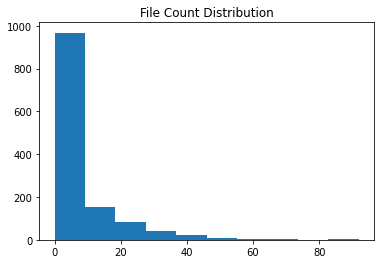

In [29]:
plt.hist(sizes.values())
plt.title("File Count Distribution")
plt.show()

In [39]:
# Find the number of species with a minimum count of images from fishbase
thresh = 25
mtt_species= []
for species, count in sizes.items():
    if count > thresh:
        mtt_species.append(species)
print(len(mtt_species))

99


### Find Scraped Image Counts for the Species that Meet IsFish Threshold 

In [80]:
data_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224)), ]) #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [83]:
# Method to parse a given directory and find the number of fish vs nonfish images
def count_fish(species_path):
    fish_count = 0
    not_fish_count = 0
    deltas = []
    for file in os.listdir(species_path):
        image_path = species_path + file
        try:
            img = Image.open(image_path).convert('RGB')
        except:
            continue
        img_filt = data_transforms(img).cuda().unsqueeze(0)
        outputs = model_ft(img_filt)

        _, preds =torch.max(outputs, 1)
        preds = preds.tolist()
        fish_score = outputs.tolist()[0][0]
        not_fish_score = outputs.tolist()[0][1]
        delta = fish_score - not_fish_score 
        preds = preds[0]
        # 1 is for not fish and 0 is for fish
        mod_pred = delta > -2

        if mod_pred == 1:
            fish_count += 1

        else:
            not_fish_count += 1 
            deltas.append(delta)
            
    return fish_count, not_fish_count, deltas
            

In [85]:
sci_path = "/media/shivaram/SharedVolum/Projects/FishID/scraped_images/scientific/" 
scientific_counts = dict()
for species_id in mtt_species:
    
    try:
        species_path = sci_path + species_id + "/"
        ic, _, _ = count_fish(species_path)
    except:
        ic = 0
    scientific_counts[species_id] = ic
    

In [90]:
common_path = "/media/shivaram/SharedVolum/Projects/FishID/scraped_images/regular/" 
common_counts = dict()
for species_id in mtt_species:
    try:
        species_path = common_path + species_id + "/"
        ic, _, _ = count_fish(species_path)
    except:
        ic = 0
    common_counts[species_id] = ic

In [97]:
# Find fish classes that have enough train data
all_thresh_ids = []
train_thresh = 50
for fid in mtt_species:
    if common_counts[fid] > train_thresh and scientific_counts[fid] > train_thresh:
        all_thresh_ids.append(fid)
print(len(all_thresh_ids))

92
